# 9章　クラス分類 III：音楽ジャンル分類

### ざっくり概要

* 音の単純な特徴量は、「周波数と位相が異なるサイン波(正弦波)」
* 良いモデルとは偽陽性率が低い時点で既に真陽性率が高い数値となる
* 分類器の評価方法
  * 「混合行列」は、全体の傾向を見るのに有効で、対角線上が高い数値であれば良い
  * 「ROC曲線」は、個別の評価を見るのによく、曲面積(AUC)が大きくなれば良い
* 分類器の改善には、無理せず適切な特徴量を利用しましょう

## 9.3 音楽を見る

スペクトログラムで可視化してみる

スペクトログラム（英: Spectrogram）:複合信号を窓関数に通して、周波数スペクトルを計算した結果を指す。  
3次元のグラフ（時間、周波数、信号成分の強さ）で表される。

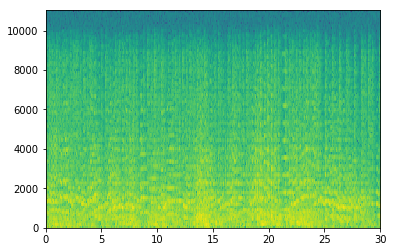

In [24]:
import scipy.io.wavfile as wio
import matplotlib.pyplot as plt

# クラシックのスペクトログラム
rate, data = wio.read("./classical.00000.wav")
pxx, freq, bins, t = plt.specgram(data,Fs  = rate) 
plt.show()

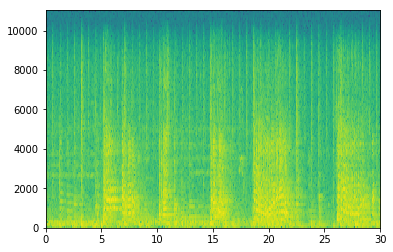

In [25]:
# ブルースのスペクトログラム
rate, data = wio.read("./blues.00099.wav")
pxx, freq, bins, t = plt.specgram(data,Fs  = rate) 
plt.show()

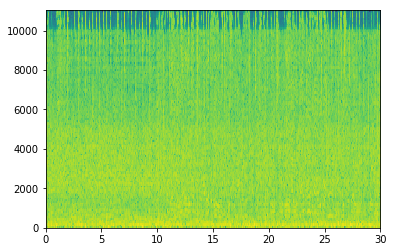

In [26]:
# メタルのスペクトログラム
rate, data = wio.read("./metal.00000.wav")
pxx, freq, bins, t = plt.specgram(data,Fs  = rate) 
plt.show()

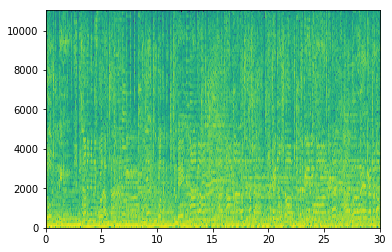

In [27]:
# カントリーのスペクトログラム
rate, data = wio.read("./country.00000.wav")
pxx, freq, bins, t = plt.specgram(data,Fs  = rate) 
plt.show()

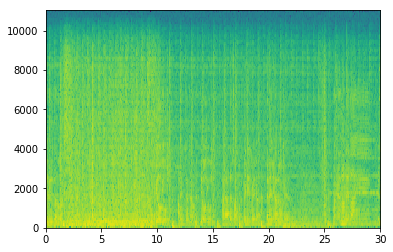

In [28]:
# ロックのスペクトログラム
rate, data = wio.read("./rock.00000.wav")
pxx, freq, bins, t = plt.specgram(data,Fs  = rate) 
plt.show()

⇒ジャンルによってスペクトログラムに差があるように見える。  
　単純な仮説として「スペクトログラムの類似」で音楽ジャンルが推定できるのではと考える

## 9.3.1 音楽をサイン波に分解する

### sox.exeでの音声データ作成
C:\Users\tomohiro-odan\Jupyter_notebook\chapter_9>"C:\Program Files (x86)\sox-14-4-2\sox.exe" --null -r 22050 sine_a.wav synth 0.2 sine 400
C:\Users\tomohiro-odan\Jupyter_notebook\chapter_9>"C:\Program Files (x86)\sox-14-4-2\sox.exe" --null -r 22050 sine_b.wav synth 0.2 sine 3000
C:\Users\tomohiro-odan\Jupyter_notebook\chapter_9>"C:\Program Files (x86)\sox-14-4-2\sox.exe" --combine mix --volume 1 sine_b.wav --volume 0.5 sine_a.wav sine_mix.wav

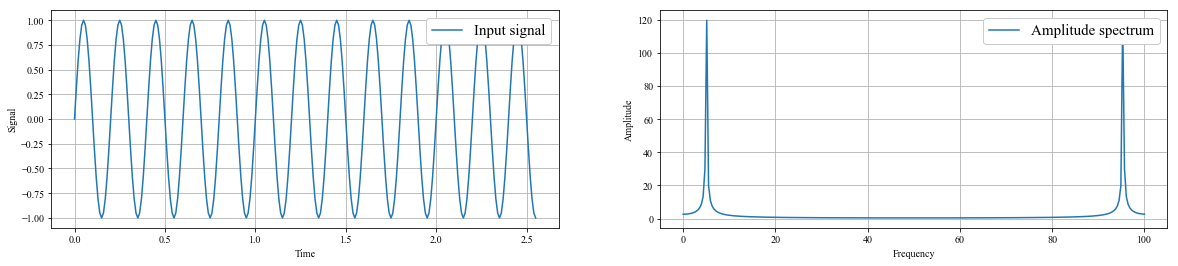

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# データのパラメータ
N = 256            # サンプル数
dt = 0.01          # サンプリング間隔
f1 = 5    # 周波数
t = np.arange(0, N*dt, dt) # 時間軸
freq = np.linspace(0, 1.0/dt, N) # 周波数軸

# 単純な例
# 信号を生成（周波数10のサイン波）
f = np.sin(2*np.pi*f1*t) 
    
# 高速フーリエ変換
F = np.fft.fft(f)

# 振幅スペクトルを計算
Amp = np.abs(F)

# グラフ表示
plt.figure(figsize=(20, 4))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.subplot(121)
plt.plot(t, f, label='Input signal')
plt.xlabel("Time", fontsize=10)
plt.ylabel("Signal", fontsize=10)
plt.grid()
leg = plt.legend(loc=1, fontsize=15)
leg.get_frame().set_alpha(1)
plt.subplot(122)
plt.plot(freq, Amp, label='Amplitude spectrum')
plt.xlabel('Frequency', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.grid()
leg = plt.legend(loc=1, fontsize=15)
leg.get_frame().set_alpha(1)
plt.show()

## 9.4.2 分類器の訓練を行う

In [30]:
サンプル問題をやってみる？

SyntaxError: invalid character in identifier (<ipython-input-30-fa2890cdb80b>, line 1)

## 9.4.3 混合行列を用いて多クラス問題の正解率を計算する

In [ ]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred,title):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True, cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(df_cmx)

# 正解と得られた結果    
test_y = ["a","b","c","d","e","e"]
predict_y = ["a","b","c","d","e","a"]

# 縦軸が正しいクラス、横軸が予測クラス
# 右の行列が正解、左の行列がその時の予測結果
print_cmx(test_y,predict_y,'sample graph')

「混合行列」は、全体の傾向を見るのに有効で、対角線上が高い数値であれば良い

## 9.4.4 ROC曲線によるクラス分類器の評価方法

ROC曲線では下記を利用する
* False Positive Rate(偽陽性率）：FP/(FP+TN)
* True Positive Rate(真陽性率）：TP/(TP+FN)

ROC曲線の利用上のメリット：
* False Positive RateとTrue Positive Rateを用いるので、クラス間のデータ数の偏りによる影響を受けない

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import pylab as pl
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

random_state = np.random.RandomState(0)

# サンプルデータ
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# テストセットの作成
X, y = shuffle(X, y, random_state=random_state)
half = int(n_samples / 2)
X_train, X_test = X[:half], X[half:]
y_train, y_test = y[:half], y[half:]

# 分類
classifier = svm.SVC(kernel='linear', probability=True)
probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)

# ROCとAUCの作成
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# ROC曲線をプロット
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

In [ ]:
# 正解と得られた結果   
print(y_test)
print(probas_[:, 1])

「ROC曲線」は、個別の評価を見るのによく、曲面積が大きくなれば良い  
⇒良いモデルとは偽陽性率が低い時点で既に真陽性率が高い数値がでること

## 9.5 メル周波数ケプストラム係数を用いて分類器を改良する

In [ ]:
import librosa

# クラシックのメル周波数ケプストラム係数
x, fs = librosa.load('./classical.00000.wav', sr=22050)
mfccs = librosa.feature.mfcc(x, sr=fs)
print(mfccs.shape)

## まとめ

* どんな特徴量を利用したらよいかはそのドメイン次第 
* 単純な特徴量をまず利用し、徐々に洗練させていく
  
音声データの場合、音声でいた特有の特徴量を手掛かりに、下記の前提を置いて、分類器を改良していた 
* 人の聴覚が持つ特徴量を利用する
* 音声全体の流れを利用する（今回はMFCCの平均値）
* 楽曲データの最初と最後は楽曲のジャンルの分類には特徴的でないメロディである

## 用語

* 適合率:(precision, 精度)とは、システムが出した結果において、本当に正しかったものの割合のこと。
* 再現率:(recall)とは、結果として出てくるべきもののうち、実際に出て来たものの割合。

# 参考文献

* [音声データ](http://opihi.cs.uvic.ca/sound/genres.tar.gz)
* [ソースコード](https://github.com/luispedro/BuildingMachineLearningSystemsWithPython/tree/first_edition)
* [音声言語処理特論](http://www.slp.cs.tut.ac.jp/~kyama/Lecture/AdvSLP/slide/AdvSLP_02.pdf)
* [フォーマット変換ツール:soxの使い方](http://www.xucker.jpn.org/pc/sox_use1.html)
* https://qiita.com/martin-d28jp-love/items/34161f2facb80edd999f
* [声優の声を分類してみた](https://qiita.com/1234224576/items/f785eef6eed68271be64)
* [ROC,AUC](http://www.randpy.tokyo/entry/roc_auc)